# Projeto Final

Este é o projeto final da disciplina Aprendizado de Máquina (IA006-C), ministrado pelos professores Levy Boccato e Romis, na Unicamp no 2S2019.

## Projeto

A ideia do projeto é permitir a clusterização de conteúdo textual, para que a partir deste seja criado um chatbot.

Os textos passarão pro um processo de clusterização (e aqui serão apresentados duas técnicas para gerar o espaço vetorial de documentos [TF-IDF e Doc2Vec]) usando o algoritmo KMeans e usando duas métricas para cálculo das distâncias dos documentos no espaço vetorial desejado.

Posterior a isso, textos que não forem similares (ou proximamente similares aos já "classificados") serão considerados como anomalias e por conseguintes novos clusters poderão ser gerados futuramente.

In [40]:
import re
from unicodedata import normalize
from string import punctuation
import warnings
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import spacy
import nltk
from nltk.cluster import KMeansClusterer
from nltk.corpus import stopwords
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding
from sklearn.decomposition import NMF
from sklearn.cluster import DBSCAN, OPTICS, KMeans
# from pyclustering.cluster.xmeans import xmeans, kmeans
# from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, BatchNormalization, MaxPooling1D, AveragePooling1D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.optimizers import SGD, RMSprop, Adam
from keras import regularizers

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

warnings.filterwarnings('ignore')
np.random.seed(123456)

%matplotlib inline

In [13]:
def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

def is_number(s):
    try:
        complex(s) # for int, long, float and complex
    except ValueError:
        return False
    return True

def tokenizer(phrase):
    phrase = phrase.lower()
    for o, r in RM:
        phrase = re.sub(o, r, phrase, flags=re.MULTILINE)
    phrase = NLP(re.sub(r'["\'@#%\(\)]', "", phrase), disable=["parser"])
    clean_frase = []
    for palavra in phrase:
        if palavra.pos_ != "PUNCT":
            word = palavra.text.strip()
            if not is_number(word) and word not in STOPWORDS and len(word) > 1:
                # clean_frase += [STEMMER.stem(remover_acentos(palavra.lemma_))]
                clean_frase += [STEMMER.stem(remover_acentos(palavra.lemma_))]
    return clean_frase

def _get_stopwords():
    stpwords = stopwords.words('portuguese') + list(punctuation)
    rms = ['um', 'não', 'mais', 'muito']
    for rm in rms:
        del stpwords[stpwords.index(rm)]
    return stpwords

NLP = spacy.load("pt")
# STEMMER = nltk.stem.RSLPStemmer()
STEMMER = nltk.stem.SnowballStemmer('portuguese')
STOPWORDS = _get_stopwords()
RM = [
    ('\n', '. '), ('"', ''), ('@', ''),
    ('#', ''), ('RT', ''), (r'(http[s]*?:\/\/)+.*[\r\n]*', '')
]

colors = np.asarray([
    (230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240),
    (240, 50, 230), (210, 245, 60), (250, 190, 190), (0, 128, 128), (230, 190, 255), (170, 110, 40), (255, 250, 200),
    (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (0, 0, 0),
    (141, 204, 226), (212, 50, 147), (251, 226, 93), (16, 185, 176), (189, 182, 163), (244, 172, 18), (100, 28, 112),
    (165, 124, 92), (183, 160, 211), (66, 47, 105), (240, 67, 7), (244, 188, 198)
]).astype(np.float32)

colors /= 255.0

### Carregamento dos datasets

Os datasets de exemplos são frases já pré-categorizadas usadas em chatbots.

Contém 33 categorias e ao todo 696 documentos ou frases.

In [14]:
df_data1 = pd.read_csv("intents.csv", sep=';', names=["cluster", "perguntas"])
df_data2 = pd.read_csv("ground_truth.csv", sep=';', names=["perguntas", "cluster"])

df_data1 = df_data1[df_data1.columns[::-1]]
df_data = pd.concat([df_data1, df_data2], sort=False)
df_data.dropna(inplace=True)
df_data['cluster'] = df_data['cluster'].str.upper()

T = df_data.to_numpy()
index = np.random.choice(T.shape[0], 10, replace=False)
display(df_data.iloc[index].sort_values(by=["cluster"]))

c = np.argmax(pd.get_dummies(df_data["cluster"]).to_numpy(), axis=1)

N = df_data["cluster"].to_numpy().shape[0]
clusters = len(set(c))

,perguntas,cluster
212,esta dando erro ao tentar criar meu novo username,ACCOUNT
234,"estou tentanto criar meu username, mas não estou conseguindo",ACCOUNT
50,Eu vou sair de férias em breve. Eu preciso adicionar chamadas internacionais para o meu plano.,ACTIVATE_ROAMING
250,como solicitar um novo certificado digital para um sistema que criei no me departamento?,CERTIFICATE
159,Quero que meu aparelho pare de buscar sinal quando chego em um novo país,DEACTIVATE_ROAMING
204,"Preciso de informações sobre plano de chamada internacional, o que você sugere?",INTERNATIONAL_RATE_PLAN_INQUIRY
249,Por favor me ajude desbloquear meu novo telefone no meu plano de serviço.,NETWORK_UNLOCK
242,Você pode explicar como desbloquear um gflex por favor?,NETWORK_UNLOCK
291,quero instalar a vpn,REMOTE_ACCESS
77,obrigado mesmo,THANK_YOU


In [15]:
uniq, cnt = np.unique(np.asarray(df_data["cluster"]), return_counts=True)
df_org = pd.DataFrame(np.array(list(zip(uniq, cnt))), columns=["Categoria", "Qtde"])

print("Qtde. de documentos por categoria:")
display(df_org.sort_values(by=["Categoria"]))

Qtde. de documentos por categoria:


,Categoria,Qtde
0,ACCOUNT,29
1,ACTIVATE_DEVICE,19
2,ACTIVATE_PREPAID_PLAN,21
3,ACTIVATE_ROAMING,20
4,ADD_INSURANCE,18
5,ADD_SERVICE_FEATURES,20
6,BAD_WORDS,24
7,BOT_FOUND,20
8,BOT_NAME,16
9,CERTIFICATE,18


In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_data["perguntas"], c, test_size=0.2)

qtde_docs = len(df_data["perguntas"])
qtde_categ = len(df_data["cluster"])
print(f"Total docs     : {qtde_docs}")
print(f"Total cluster  : {qtde_categ}")
print(f"X_train size   : {X_train.shape}")
print(f"X_test  size   : {X_test.shape}")

Total docs     : 697
Total cluster  : 697
X_train size   : (557,)
X_test  size   : (140,)


### Dataset tokenization

In [17]:
P = X_train.shape[0]
print("Tokenization...")
documents_d2c = [TaggedDocument(tokenizer(doc), [i]) for i, doc in enumerate(X_train)]
print("Qtd documentos treino: ", len(documents_d2c))
print("Qtd Intents treino   : ", len(np.unique(df_data["cluster"].to_numpy())))
print("Finished...")

Tokenization...
Qtd documentos treino:  557
Qtd Intents treino   :  33
Finished...


In [18]:
documents_d2c[:10]

[TaggedDocument(words=['precis', 'viaj', 'vancouv', 'quantum', 'cust', 'roaming', 'mes'], tags=[0]),
 TaggedDocument(words=['qual', 'outr', 'servic', 'bot', 'oferec'], tags=[1]),
 TaggedDocument(words=['um', 'nom'], tags=[2]),
 TaggedDocument(words=['tent', 'ativ', 'nov', 'telefon', 'servic', 'pre-pag'], tags=[3]),
 TaggedDocument(words=['porqu', 'disposit', 'aind', 'pendent', 'ativ'], tags=[4]),
 TaggedDocument(words=['quantum', 'pag', 'mais', 'gbs', 'plan'], tags=[5]),
 TaggedDocument(words=['nenhum', 'opca', 'quer', 'faz'], tags=[6]),
 TaggedDocument(words=['nao', 'precis', 'mais', 'nad', 'obrig'], tags=[7]),
 TaggedDocument(words=['pod', 'faz', 'cham', 'internacional', 'diret', 'celul'], tags=[8]),
 TaggedDocument(words=['pox', 'nao', 'quer', 'fal', 'um', 'chatbot', 'quer', 'um', 'human', 'verdad'], tags=[9])]

### **Doc2Vec**

Parâmetros iniciais... quantidade de dimensões dos vetores gerados para cada frase, épocas de treinamento e épocas de posterior inferência para novas frases.

A quantidade de épocas de inferência, sugere-se ser bem superior as de treinamento.

In [23]:
dim = 500
epochs = 100
M = 12000

print(f"Dimensions   : {dim}")
print(f"Epochs       : {epochs}")
print(f"Infer Epochs : {M}")

Dimensions   : 500
Epochs       : 100
Infer Epochs : 12000


In [24]:
print("Starting model...")
common_kwargs = dict(
    dm=0, vector_size=dim, epochs=epochs, workers=4, 
    window=10, min_count=2, alpha=1e-2, min_alpha=1e-4,
    hs=1, negative=7, dbow_words=1, sample=0
)
d2v = Doc2Vec(**common_kwargs)
print("Building vocab...")
d2v.build_vocab(documents_d2c)
print("Training...")
d2v.train(
    documents_d2c,
    total_examples=d2v.corpus_count,
    epochs=d2v.epochs
)
print("Finish...")

Starting model...
Building vocab...
Training...
Finish...


Validação do modelo gerado pelo Doc2Vec... teste tanto nos dados apresentados para treinamento quanto nos dados de testes e as acurácias alcançadas.

In [71]:
def validate(xt):
    new_doc_vec = d2v.infer_vector(tokenizer(xt[0]), epochs=M)
    sim = d2v.docvecs.most_similar(positive=[new_doc_vec], topn=1)
    return xt[1] == y_train[sim[0][0]]

dc = np.c_[X_train, y_train]
with ProcessPoolExecutor(max_workers=4) as exc:
    elms = utils.shuffle([doc for doc in dc], n_samples=100)
    acc = list(exc.map(validate, elms, chunksize=25))
    print("- Acurácia treino:", np.round(np.mean(acc) * 100, 2))

def validate(xt):
    new_doc_vec = d2v.infer_vector(tokenizer(xt[0]), epochs=M)
    sim = np.array(d2v.docvecs.most_similar(positive=[new_doc_vec], topn=30))
    unq, cnt = np.unique(y_train[sim[:, 0].astype(np.int32)], return_counts=True)
    if unq[np.where(cnt == np.max(cnt))[0][0]] == y_train[sim[0][0].astype(np.int32)]:
        return xt[1] == y_train[sim[0][0].astype(np.int32)]
    return xt[1] == unq[np.where(cnt == np.max(cnt))[0][0]]

accc = []
dc = np.c_[X_test, y_test]
with ProcessPoolExecutor(max_workers=4) as exc:
    for p in range(5):
        elms = utils.shuffle([doc for doc in dc], n_samples=100)
        acc = list(exc.map(validate, elms, chunksize=25))
        print(f" - Acurácia teste {p+1}  :", np.round(np.mean(acc) * 100, 2))
        accc += acc
print("- Acurácia média teste:", np.round(np.mean(accc) * 100, 2))

- Acurácia treino: 100.0
 - Acurácia teste 1  : 51.0
 - Acurácia teste 2  : 47.0
 - Acurácia teste 3  : 49.0
 - Acurácia teste 4  : 54.0
 - Acurácia teste 5  : 53.0
- Acurácia média teste: 50.8


#### Clusterização

Utilizou-se o KMeans definindo a quantidade de clusters para o número ideal de categorias existentes no caso 33. A métrica de distância utilizada, não foi a euclidiana, mas sim a de cosseno (métrica comumente usada na classificação de texto em seu espaço vetorial).

In [11]:
X = d2v.docvecs.vectors_docs
XT = np.array([d2v.infer_vector(tokenizer(doc), epochs=M) for doc in X_test])

In [12]:
kclusterer = KMeansClusterer(clusters, distance=nltk.cluster.util.cosine_distance, repeats=30, avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
assigned_clusters = np.array(assigned_clusters).ravel()
centroids = kclusterer.means()

In [13]:
docs = np.asarray(X_train)

info = []
frases = []
for i in range(clusters):
    idx = np.where(assigned_clusters == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["perguntas", "cluster"])
df_inf = pd.DataFrame(np.array([np.asarray(info)[:, 1]]), columns=[f"C{i}" for i in range(clusters)])

print("Frases por cluster:")
display(df.sort_values(by=["cluster"]))

print("Documentos por cluster:")
display(df_inf)

Frases por cluster:


,perguntas,cluster
0,Quanto é o custo de um plano familiar de 3 linhas?,0
11,O equipamento deve ser devolvido à empresa quando você cancela o meu serviço?,0
10,Eu gostaria de cancelar o serviço de encaminhamento das minhas ligações. Como faço isso?,0
8,meu usuario esta cancelado,0
7,é permitido que patrulheiros tenham uma conta?,0
...,...,...
550,"Olá, eu tenho um novo dispositivo, e um cartão SIM de vocês com contrato mensal que obtive em uma loja, e já passaram 24 horas e o SIM ainda não está funcionando, e a loka está dizendo que tudo está ativado da parte deles",32
551,Quero sua ajuda para colocar o dinheiro no meu cartão SIM.,32
552,Como posso registrar um cartão SIM?,32
553,"Eu não posso recarregar porque diz que meu sim está desativado , meu sim pode ser ativado?",32


Documentos por cluster:


,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32
0,12,17,21,15,20,14,8,12,18,25,12,14,17,25,11,21,26,15,17,19,20,29,15,29,19,13,18,12,15,14,15,8,10


#### Visualização

Apresentação dos protótipos gerados pelo KMeans, reduzindo a dimensão usando o algoritmo MDS (Multidimensional Scaling).

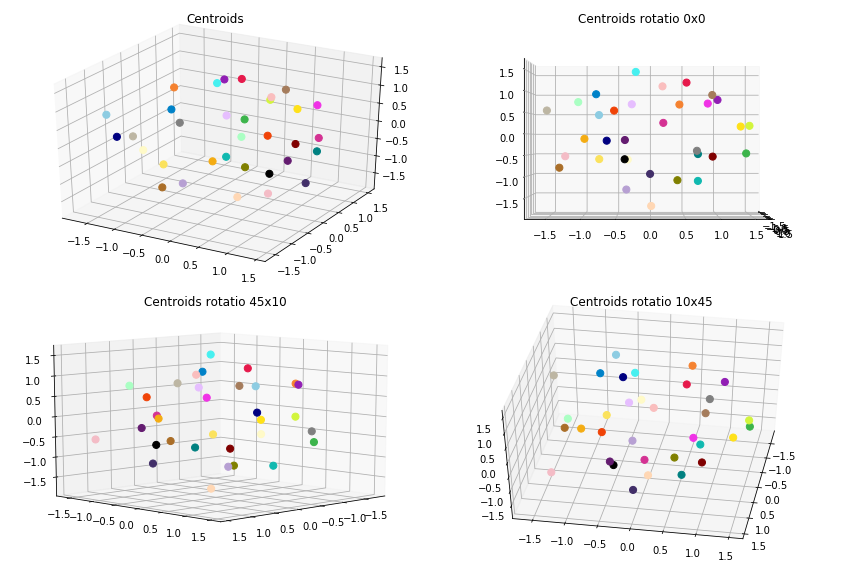

In [14]:
mds = MDS(
    n_components=3,
    n_init=5,
    max_iter=500,
    random_state=0,
    n_jobs=-1
)
X_cnt = mds.fit_transform(centroids)

plt.figure(figsize=(12, 8))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title("Centroids")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title("Centroids rotatio 0x0")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(0, 0)
ax = plt.subplot(2, 2, 3, projection='3d')
plt.title("Centroids rotatio 45x10")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(10, 45)
ax = plt.subplot(2, 2, 4, projection='3d')
plt.title("Centroids rotatio 10x45")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(45, 10)
plt.tight_layout()
plt.show()

#### Clusterização dos dados de Teste

Por fim, realizada a clusterização dos dados de teste e a apresentação das 8 primeiras frases do conjunto de teste juntamente com outras duas frases do cluster ao qual foi identificado como o melhor.

In [15]:
Xtest = X_test.to_numpy()
for i, xt in enumerate(XT[:8]):
    clt = kclusterer.classify(xt)
    print("*", Xtest[i])
    for frase in utils.shuffle(df[df["cluster"] == clt].to_numpy())[:2]:
        print("  - ", frase[0])
    print("-" * 20)

* Quanto da área total no meu país é coberta pela recepção?
  -  pqp, seu merda, responde certo porra!
  -  Estou planejando uma viagem ao Havaí e estava pensando se eu vou ter sinal lá.
--------------------
* acesso ao meu email foi negado
  -  gostaria de informações sobre acesso remoto
  -  meu email esta sem acesso
--------------------
* voce nao conseguiu me ajudar, quero falar com um humano
  -  Não consigo iniciar o bluetooth para emparelhar com o fone de ouvido, o que devo fazer?
  -  voce nao conseguiu me ajudar, quero falar com um atendente
--------------------
* voce nao sabe nada sobre vpn?
  -  é para colocar minha senha do meu departamento ou outra?
  -  qual usuario e senha usar para acessar os sistemas?
--------------------
* Posso usar o meu telefone quando estou no exterior de férias e quais serão as tarifas?
  -  Há alguma limitação quanto aos países no exterior que eu posso chamar e acessar do meu país de origem?
  -  Meu telefone pode rastrear quando uso internet n

#### Métricas

Abaixo são apresentadas métricas para demonstrar o quanto a clusterização parece funcionar.

In [16]:
hom = homogeneity_score(y_test, [kclusterer.classify(xt) for xt in XT])
compl = completeness_score(y_test, [kclusterer.classify(xt) for xt in XT])
silh = silhouette_score(XT, labels=[kclusterer.classify(xt) for xt in XT], metric="cosine", random_state=0)

print("Homogeneidade: ", np.round(hom, 3))
print("Completude   : ", np.round(compl, 3))
print("Silhouette   : ", np.round(silh, 3))

Homogeneidade:  0.709
Completude   :  0.705
Silhouette   :  -0.019


Como exemplo de comparação, foi executado o mesmo algoritmo de clusterização (conforme apresentado acima) entretanto variando a quantidade do número de clusters para verificar como as métricas se comportam.

In [17]:
t_cluster = 40

clusterizacao = []
for k in range(2, t_cluster):
    kclusterer_ = KMeansClusterer(k, distance=nltk.cluster.util.cosine_distance, repeats=1, avoid_empty_clusters=True)
    assigned_clusters = kclusterer_.cluster(X, assign_clusters=True)
    
    hom = homogeneity_score(y_test, [kclusterer_.classify(xt) for xt in XT])
    compl = completeness_score(y_test, [kclusterer_.classify(xt) for xt in XT])
    silh = silhouette_score(XT, labels=[kclusterer_.classify(xt) for xt in XT], metric="cosine", random_state=0)

    clusterizacao.append({
        "Qtd. Cluster": k,
        "Homogeneity": np.round(hom, 3),
        "Completeness": np.round(compl, 3),
        "Silhouette": np.round(silh, 3),
    })

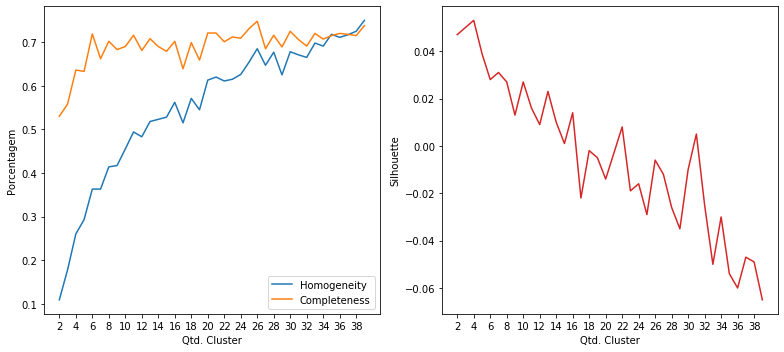

In [18]:
df_cluster = pd.DataFrame(clusterizacao, columns=["Qtd. Cluster", "Homogeneity", "Completeness", "Silhouette"])

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Homogeneity"], label="Homogeneity")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Completeness"], label="Completeness")
plt.xticks(range(2, 40, 2))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Porcentagem")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Silhouette"], c="C3")
plt.xticks(range(2, 40, 2))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

---

### **TF-IDF**

No caso do tf-idf, assim como no doc2vec foi escolhido um máximo de até 1000 features (ou dimensões). Entretanto, diferentemente do doc2vec o tf-idf não adiciona dimensões caso a quantidade de termos (palavras) seja inferior a esse máximo, mas ele corta caso for maior.

In [21]:
P = X_train.shape[0]
print("Tokenization...")
documents_tfidf = [" ".join(tokenizer(doc)) for doc in X_train]
print("Qtd documentos treino: ", len(documents_tfidf))
print("Qtd Intents treino   : ", len(np.unique(df_data["cluster"].to_numpy())))
print("Finished...")

Tokenization...
Qtd documentos treino:  556
Qtd Intents treino   :  33
Finished...


In [22]:
documents_tfidf[:10]

['quer mud servic um nov disposit mant mesm dar pessoal pod diz faze-l',
 'qual outr servic bot oferec',
 'um nom',
 'possivel algu acompanh atrav etap ativ disposit pre-pag',
 'precis faz ativ nov telefon pre-pag remov restrica',
 'nao consegu inic bluetooth emparelh fon ouv dev faz',
 'nenhum opca quer faz',
 'nao precis mais nad obrig',
 'foi-m promet cobertur total cidad inscrev ano pass mes dois cidad nao conexa consert',
 'acess remot sistem empres cas']

In [23]:
tfidf = TfidfVectorizer(max_features=1000)
X_trans = tfidf.fit_transform(documents_tfidf)

Validação do modelo gerado pelo TF-IDF... teste tanto nos dados apresentados para treinamento quanto nos dados de testes e as acurácias alcançadas.

In [24]:
T = 75

dc = np.c_[X_train, y_train]
docs = utils.shuffle([doc for doc in dc])[:T]
docs = [" ".join(tokenizer(doc)) for doc, y in docs]
sim = np.round(1 - cosine_similarity(tfidf.transform(docs)), 3)
acc = []
for i, xt in enumerate(dc[:T]):
    acc.append(xt[1] == dc[np.where(sim[i] <= 0.3)][0][1])
print("- Acurácia treino:", np.round(np.mean(acc) * 100, 2))
print("-" * 20)


def validate(p):
    acc = []
    docs1 = utils.shuffle([doc for doc in dc])[:T]
    docs = [" ".join(tokenizer(doc)) for doc, y in docs1]
    sim = np.round(1 - cosine_similarity(tfidf.transform(docs), X_trans), 3)
    for i, xt in enumerate(docs1[:T]):
        dcs = np.where(sim[i] <= 0.3)
        it = 0.35
        while len(dcs[0]) == 0:
            dcs = np.where(sim[i] <= it)
            it += 0.05
        acc.append(xt[1] == y_train[dcs[0][0]])
    return acc

accc = []
dc = np.c_[X_test, y_test]
with ProcessPoolExecutor(max_workers=5) as exc:
    accs = exc.map(validate, range(5))
    for p, acc in enumerate(accs):
        print(f" - Acurácia teste {p+1}  :", np.round(np.mean(acc) * 100, 2))
        accc += acc
print("- Acurácia média teste:", np.round(np.mean(accc) * 100, 2))

- Acurácia treino: 100.0
--------------------
 - Acurácia teste 1  : 65.33
 - Acurácia teste 2  : 65.33
 - Acurácia teste 3  : 62.67
 - Acurácia teste 4  : 66.67
 - Acurácia teste 5  : 69.33
- Acurácia média teste: 65.87


#### Clusterização

Utilizou-se o KMeans definindo a quantidade de clusters para o número ideal de categorias existentes no caso 33. A métrica de distância utilizada, não foi a euclidiana, mas sim a de cosseno (métrica comumente usada na classificação de texto em seu espaço vetorial).

In [25]:
X = np.array(tfidf.transform(documents_tfidf).todense())
XT = np.array(tfidf.transform([" ".join(tokenizer(doc)) for doc in X_test]).todense())

In [26]:
kclusterer = KMeansClusterer(clusters, distance=nltk.cluster.util.cosine_distance, repeats=30, avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
assigned_clusters = np.array(assigned_clusters).ravel()
centroids = kclusterer.means()

In [27]:
docs = np.asarray(X_train)

info = []
frases = []
for i in range(clusters):
    idx = np.where(assigned_clusters == i)[0]
    for doc in docs[idx]:
        frases.append([doc, i])
    info.append([i, len(docs[idx])])

df = pd.DataFrame(frases, columns=["perguntas", "cluster"])
df_inf = pd.DataFrame(np.array([np.asarray(info)[:, 1]]), columns=[f"C{i}" for i in range(clusters)])

print("Frases por cluster:")
display(df.sort_values(by=["cluster"]))

print("Documentos por cluster:")
display(df_inf)

Frases por cluster:


,perguntas,cluster
0,você tem um nome?,0
13,vc tem nome?,0
12,qual o nome que atribuiram a você?,0
11,qual é o seu nome?,0
9,valeu,0
...,...,...
544,Eu estive dirigido muito recentemente e foi praticamente impossível usar o serviço em algumas áreas. Você poderia me fornecer uma lista de locais / áreas com pouca ou nenhuma recepção?,32
543,"Olá, estava imaginando se essa queda de rede já foi consertada? Já existe uma cobertura LTE nesta área?",32
554,Qual é a área de cobertura e confiabilidade de recepção?,32
548,Poderia por favor compartilhar alguma informação sobre a cobertura de rede na área?,32


Documentos por cluster:


,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32
0,14,35,21,21,14,10,26,7,14,20,18,11,20,15,19,9,3,23,11,25,17,17,17,22,19,19,38,8,20,4,14,12,13


#### Visualização

Apresentação dos protótipos gerados pelo KMeans, reduzindo a dimensão usando o algoritmo MDS (Multidimensional Scaling).

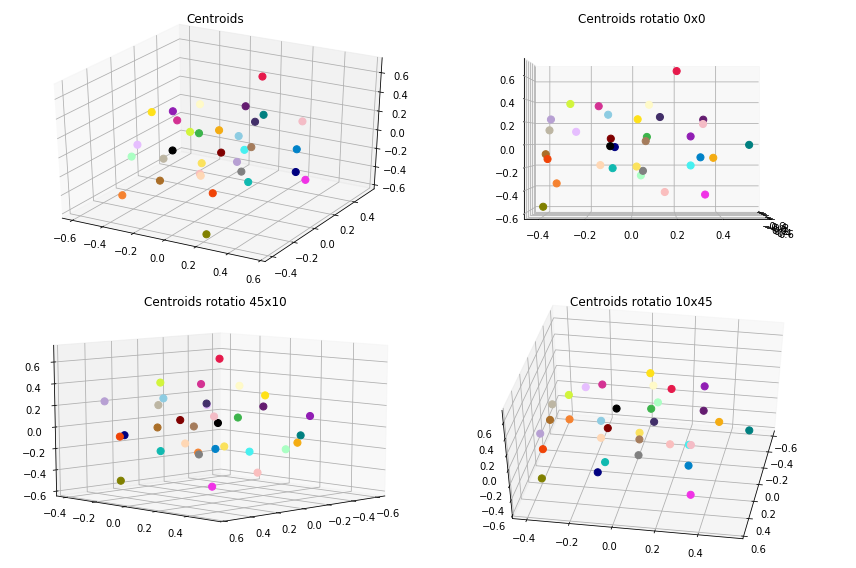

In [28]:
mds = MDS(
    n_components=3,
    n_init=5,
    max_iter=500,
    random_state=0,
    n_jobs=-1
)
X_cnt = mds.fit_transform(centroids)

plt.figure(figsize=(12, 8))
ax = plt.subplot(2, 2, 1, projection='3d')
plt.title("Centroids")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax = plt.subplot(2, 2, 2, projection='3d')
plt.title("Centroids rotatio 0x0")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(0, 0)
ax = plt.subplot(2, 2, 3, projection='3d')
plt.title("Centroids rotatio 45x10")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(10, 45)
ax = plt.subplot(2, 2, 4, projection='3d')
plt.title("Centroids rotatio 10x45")
ax.scatter(X_cnt[:, 0], X_cnt[:, 1], X_cnt[:, 2], c=colors, alpha=1, s=50)
ax.view_init(45, 10)
plt.tight_layout()
plt.show()

#### Clusterização dos dados de Teste

Por fim, realizada a clusterização dos dados de teste e a apresentação das 8 primeiras frases do conjunto de teste juntamente com outras duas frases do cluster ao qual foi identificado como o melhor.

In [29]:
Xtest = X_test.to_numpy()
for i, xt in enumerate(XT[:8]):
    clt = kclusterer.classify(xt)
    print("*", Xtest[i])
    for frase in utils.shuffle(df[df["cluster"] == clt].to_numpy())[:2]:
        print("  - ", frase[0])
    print("-" * 20)

* Quanto da área total no meu país é coberta pela recepção?
  -  Oi, já que você está aqui, está havendo algum problema com a cobertura na área de SP? Desde ontem o meu sinal normal de 4 barras ficou em 0, está bem em outros lugares.
  -  Qual é a área de cobertura e confiabilidade de recepção?
--------------------
* acesso ao meu email foi negado
  -  estou tentando acessar meu email mas sem sucesso
  -  Não consigo entrar no meu e-mail
--------------------
* voce nao conseguiu me ajudar, quero falar com um humano
  -  quem e voce?
  -  pra que voce serve?
--------------------
* voce nao sabe nada sobre vpn?
  -  pra que voce serve?
  -  quais outras opcoes voce consegue responder pra mim?
--------------------
* Posso usar o meu telefone quando estou no exterior de férias e quais serão as tarifas?
  -  Como salvar contatos do telefone antigo para o telefone novo?
  -  posso fazer a configuracao em meu so sem usar a informacao de certificado digital disponibilizada?
-------------------

#### Métricas

Abaixo são apresentadas métricas para demonstrar o quanto a clusterização parece funcionar.

In [30]:
hom = homogeneity_score(y_test, [kclusterer.classify(xt) for xt in XT])
compl = completeness_score(y_test, [kclusterer.classify(xt) for xt in XT])
silh = silhouette_score(XT, labels=[kclusterer.classify(xt) for xt in XT], metric="cosine", random_state=0)

print("Homogeneidade: ", np.round(hom, 3))
print("Completude   : ", np.round(compl, 3))
print("Silhouette   : ", np.round(silh, 3))

Homogeneidade:  0.712
Completude   :  0.732
Silhouette   :  0.043


In [31]:
t_cluster = 40

clusterizacao = []
for k in range(2, t_cluster):
    kclusterer_ = KMeansClusterer(k, distance=nltk.cluster.util.cosine_distance, repeats=1, avoid_empty_clusters=True)
    assigned_clusters_ = kclusterer_.cluster(X, assign_clusters=True)
    
    hom = homogeneity_score(y_test, [kclusterer_.classify(xt) for xt in XT])
    compl = completeness_score(y_test, [kclusterer_.classify(xt) for xt in XT])
    silh = silhouette_score(XT, labels=[kclusterer_.classify(xt) for xt in XT], metric="cosine", random_state=0)

    clusterizacao.append({
        "Qtd. Cluster": k,
        "Homogeneity": np.round(hom, 3),
        "Completeness": np.round(compl, 3),
        "Silhouette": np.round(silh, 3),
    })

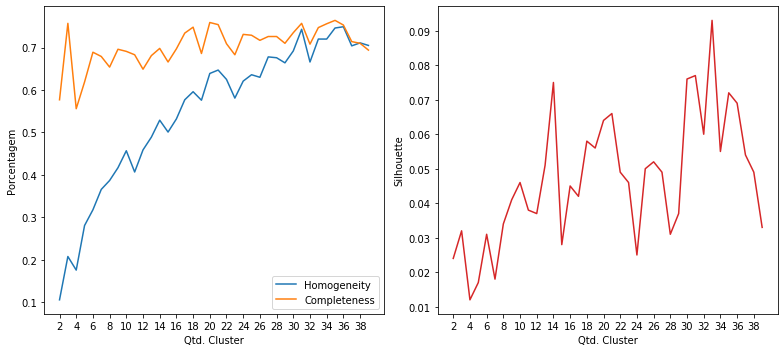

In [32]:
df_cluster = pd.DataFrame(clusterizacao, columns=["Qtd. Cluster", "Homogeneity", "Completeness", "Silhouette"])

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Homogeneity"], label="Homogeneity")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Completeness"], label="Completeness")
plt.xticks(range(2, 40, 2))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Porcentagem")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("")
plt.plot(df_cluster["Qtd. Cluster"], df_cluster["Silhouette"], c="C3")
plt.xticks(range(2, 40, 2))
plt.xlabel("Qtd. Cluster")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()